## EECS 442 Project Idea8: Brain Tumor Segmentation using 3D U-Net on MRI
Group Members: Jovan Yap (jovanyap), Xu Boyu (xuboyu), Shu Bohan (shubohan), Chan Kaiyi (kachan), Duan Lingbo (popcorna)


### SetUp
Import PyTorch

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/EECS442

/content/drive/.shortcut-targets-by-id/1w_pSrzSOj3H2lluEXNwazzJe5p_Ak2xN/EECS442


In [3]:
# Run the command in the terminal if it failed on local Jupyter Notebook, remove "!" before each line
!pip install torchsummary

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # Displays a progress bar

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchsummary import summary
from torchvision import datasets, transforms
from torch.utils.data import Dataset, Subset, DataLoader, random_split

In [5]:
# Added
!python -c "import monai" || pip install -q "monai-weekly[nibabel]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

2024-04-12 02:30:09.722049: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-12 02:30:09.722123: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-12 02:30:09.737588: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-12 02:30:09.908436: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-12 02:30:13.549384: W tensorflow/comp

In [6]:
# Added
import os
import json
import shutil
import tempfile
import time

import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib

from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai import transforms
from monai.transforms import (
    AsDiscrete,
    Activations,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.utils.enums import MetricReduction
from monai.networks.nets import SwinUNETR
from monai import data
from monai.data import decollate_batch
from functools import partial

import torch


print_config()

MONAI version: 1.3.0
Numpy version: 1.25.2
Pytorch version: 2.2.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.3.0
Nibabel version: 4.0.2
scikit-image version: 0.19.3
scipy version: 1.11.4
Pillow version: 9.4.0
Tensorboard version: 2.15.2
gdown version: 4.7.3
TorchVision version: 0.17.1+cu121
tqdm version: 4.66.2
lmdb version: 1.4.1
psutil version: 5.9.5
pandas version: 2.0.3
einops version: 0.7.0
transformers version: 4.21.3
mlflow version: 2.11.3
pynrrd version: 1.0.0
clearml version: 1.15.1

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [7]:
# install stuff that says NOT INSTALLED
!pip install pytorch-ignite itk lmdb einops mlflow pynrrd clearml

# Setup data directory

In [8]:
# setup data directory
# directory = os.environ.get("MONAI_DATA_DIRECTORY")
# can set to if want: "./Jovan_Kai_Swin_unetr_brats21_segmentation_3d/DONOTDELETE_Data_Directory"
root_dir = "/content/drive/MyDrive/EECS442/Jovan_Kai_Swin_unetr_brats21_segmentation_3d/DONOTDELETE_Saved_Checkpoints_BRATS21"
print(root_dir)


/content/drive/MyDrive/EECS442/Jovan_Kai_Swin_unetr_brats21_segmentation_3d/DONOTDELETE_Saved_Checkpoints_BRATS21


In [9]:
# Added
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = np.where(self.count > 0, self.sum / self.count, self.sum)


def datafold_read(datalist, basedir, fold=0, key="training"):
    with open(datalist) as f:
        json_data = json.load(f)

    json_data = json_data[key]

    for d in json_data:
        for k in d:
            if isinstance(d[k], list):
                d[k] = [os.path.join(basedir, iv) for iv in d[k]]
            elif isinstance(d[k], str):
                d[k] = os.path.join(basedir, d[k]) if len(d[k]) > 0 else d[k]

    tr = []
    val = []
    for d in json_data:
        if "fold" in d and d["fold"] == fold:
            val.append(d)
        else:
            tr.append(d)

    return tr, val


def save_checkpoint(model, epoch, filename="model.pt", best_acc=0, dir_add=root_dir):
    state_dict = model.state_dict()
    save_dict = {"epoch": epoch, "best_acc": best_acc, "state_dict": state_dict}
    filename = os.path.join(dir_add, filename)
    torch.save(save_dict, filename)
    print("Saving checkpoint", filename)


# added, not in original model's code
def load_checkpoint(filename, model):
    # Check if CUDA is available, and set the map_location accordingly
    map_location = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Load the checkpoint with the specified map_location
    checkpoint = torch.load(filename, map_location=map_location)

    # Apply the state_dict to the model
    model.load_state_dict(checkpoint['state_dict'])

    start_epoch = checkpoint.get('epoch', 0) + 1  # Default to 0 if not found
    best_acc = checkpoint.get('best_acc', 0.0)  # Default to 0.0 if not found
    print(f"Loaded checkpoint from epoch {checkpoint.get('epoch', 'Unknown')} with best accuracy {best_acc:.4f}")

    return start_epoch, best_acc


# Setup Dataloader

In [10]:
def get_loader(batch_size, data_dir, json_list, fold, roi):
    data_dir = data_dir
    datalist_json = json_list
    train_files, validation_files = datafold_read(datalist=datalist_json, basedir=data_dir, fold=fold)
    train_transform = transforms.Compose(
        [
            transforms.LoadImaged(keys=["image", "label"]),
            transforms.ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
            transforms.CropForegroundd(
                keys=["image", "label"],
                source_key="image",
                k_divisible=[roi[0], roi[1], roi[2]],
            ),
            transforms.RandSpatialCropd(
                keys=["image", "label"],
                roi_size=[roi[0], roi[1], roi[2]],
                random_size=False,
            ),
            transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
            transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
            transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
            transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
            transforms.RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
            transforms.RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
        ]
    )
    val_transform = transforms.Compose(
        [
            transforms.LoadImaged(keys=["image", "label"]),
            transforms.ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
            transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ]
    )

    train_ds = data.Dataset(data=train_files, transform=train_transform)

    train_loader = data.DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=8,
        pin_memory=True,
    )
    val_ds = data.Dataset(data=validation_files, transform=val_transform)
    val_loader = data.DataLoader(
        val_ds,
        batch_size=1,
        shuffle=False,
        num_workers=8,
        pin_memory=True,
    )

    return train_loader, val_loader

# Set dataset root directory and hyper-parameters

The following hyper-parameters are set for the purpose of this tutorial. However, additional changes, as described below, maybe beneficial.

If GPU memory is **not sufficient**, reduce sw_batch_size to 2 or batch_size to 1.

Decrease val_every (validation frequency) to 1 for obtaining more accurate checkpoints.

In [11]:
# data_dir = "./data/MICCAI_BraTS2020_TrainingData"
data_dir = "./"
#########SPECIFY THESE FOR EACH TRAINING EXECUTION
k_fold = 3 #either 2-fold or 3-fold
fold = 1
########
# json_list = "./Jovan_Kai_Swin_unetr_brats21_segmentation_3d/brats20_training_" + str(k_fold) + "fold.json"
json_list = "./data/brats21_folds.json"
roi = (128, 128, 128)
# original: batch_size = 2
# original: sw_batch_size = 4
batch_size = 1
sw_batch_size = 2
infer_overlap = 0.5
max_epochs = 100
# original: val_every = 10
val_every = 1
train_loader, val_loader = get_loader(batch_size, data_dir, json_list, fold, roi)

monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


# Added: Check data shape and visualize

image shape: (240, 240, 155), label shape: (240, 240, 155)


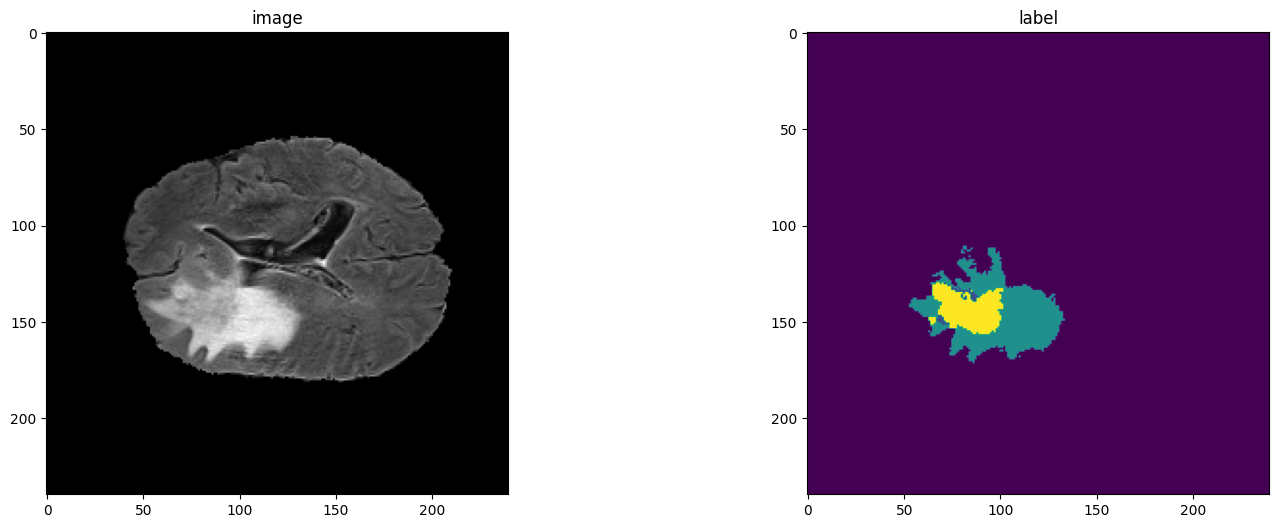

In [12]:
# Added
data_dir = "./data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_006"
# ./data/MICCAI_BraTS2020_TrainingData
# ./data/MICCAI_BraTS2020_ValidationData
img_add = os.path.join(data_dir, "BraTS20_Training_006_flair.nii")
label_add = os.path.join(data_dir, "BraTS20_Training_006_seg.nii")
img = nib.load(img_add).get_fdata()
label = nib.load(label_add).get_fdata()
print(f"image shape: {img.shape}, label shape: {label.shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[:, :, 78], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 78])
plt.show()

In [13]:
if torch.cuda.is_available():
    print("Using the GPU. You are good to go!")
    device = 'cuda'
else:
    print("Using the CPU. Overall speed may be slowed down")
    device = 'cpu'

Using the GPU. You are good to go!


# SKIPPED FROM HERE (SCROLL TO "SKIPPED UNTIL HERE")

### Load DataSet
We use BraTS2020 dataset. **Only Run this script ONCE!!**

The training dataset including ground truth segmentation labels and surv ival data, from the following link: https://www.cbica.upenn.edu/MICCAI_BraTS2020_TrainingData

The independent set of validation data (without ground truth labels) from the following link: https://www.cbica.upenn.edu/MICCAI_BraTS2020_ValidationData

In [14]:
# import os
# import requests
# import zipfile
# import shutil
# # Load the dataset and train, val, test splits
# # shutil.rmtree("./data")

# print("Loading datasets...")
# print(os.getcwd())
# os.mkdir(os.path.join(os.getcwd(), "data"))

# response = requests.get("https://www.cbica.upenn.edu/MICCAI_BraTS2020_TrainingData", stream=True)
# with open("./data/training.zip", mode="wb") as file:
#   for chunk in response.iter_content(chunk_size=10 * 1024):
#     file.write(chunk)

# with zipfile.ZipFile("./data/training.zip", 'r') as zip_ref:
#   zip_ref.extractall("./data")

# response = requests.get("https://www.cbica.upenn.edu/MICCAI_BraTS2020_ValidationData", stream=True)
# with open("./data/Validation.zip", mode="wb") as file:
#   for chunk in response.iter_content(chunk_size=10 * 1024):
#     file.write(chunk)

# with zipfile.ZipFile("./data/Validation.zip", 'r') as zip_ref:
#   zip_ref.extractall("./data")

# print("Done!")

In [15]:
# import gzip
# import shutil
# rootPath = './data/MICCAI_BraTS2020_TrainingData'
# trainingSubDir = os.listdir(rootPath)
# for subDir in trainingSubDir:
#   if subDir[-3:]=='csv':
#     continue
#   fileList = os.listdir(os.path.join(rootPath,subDir))
#   print(subDir)
#   for file in fileList:
#     if file[-2:]!='gz':
#       continue
#     with gzip.open(os.path.join(rootPath,subDir,file), 'rb') as f_in:
#       with open(os.path.join(rootPath,subDir,file[:-3]), 'wb') as f_out:
#         shutil.copyfileobj(f_in, f_out)

# rootPath = './data/MICCAI_BraTS2020_ValidationData'
# trainingSubDir = os.listdir(rootPath)
# for subDir in trainingSubDir:
#   if subDir[-3:]=='csv':
#     continue
#   fileList = os.listdir(os.path.join(rootPath,subDir))
#   print(subDir)
#   for file in fileList:
#     if file[-2:]!='gz':
#       continue
#     with gzip.open(os.path.join(rootPath,subDir,file), 'rb') as f_in:
#       with open(os.path.join(rootPath,subDir,file[:-3]), 'wb') as f_out:
#         shutil.copyfileobj(f_in, f_out)

 check the training data...



In [16]:
# import nibabel as nib
# import matplotlib.pyplot as plt

# def loadNII(filePath):
#   image = nib.load(filePath);
#   return image

# def getData(Img):
#   data = Img.get_fdata();
#   return data

# def showData(data, i, depth):
#   print(data.shape)
#   plt.subplot(2,4,i)
#   plt.imshow(data[:,:,depth])
#   plt.show()

# def saveData(data, filePath):
#   image = nib.Nifti1Image(data, np.eye(4));
#   nib.save(image, filePath)

# img = loadNII("./data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1.nii")
# data = getData(img)
# showData(data,1, 80)

# img = loadNII("./data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii")
# data = getData(img)
# showData(data,2, 80)

# img = loadNII("./data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1ce.nii")
# data = getData(img)
# showData(data,3, 80)

# img = loadNII("./data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t2.nii")
# data = getData(img)
# showData(data,4, 80)

# img = loadNII("./data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii")
# data = getData(img)
# showData(data,5, 80)

PreProcess the training data...

Preprocess

In [17]:
# !pip install SimpleITK

In [18]:
# import glob
# import SimpleITK as sitk
# import numpy as np
# import matplotlib.pyplot as plt
# def read_img(image_paths, start, end):
#     output = []
#     for image_path in image_paths[start : end]:
#         output.append(sitk.GetArrayFromImage(sitk.ReadImage(image_path)))
#     return output

# t1_train = np.array(read_img(glob.glob("./data/MICCAI_BraTS2020_TrainingData/*/*t1.nii.gz"), 0 ,10))
# t2_train =  np.array(read_img(glob.glob("./data/MICCAI_BraTS2020_TrainingData/*/*t2.nii.gz"), 0, 10))
# fl_train = np.array(read_img(glob.glob("./data/MICCAI_BraTS2020_TrainingData/*/*flair.nii.gz"), 0, 10))
# seg_train = np.array(read_img(glob.glob("./data/MICCAI_BraTS2020_TrainingData/*/*seg.nii.gz"), 0, 10))
# print(t1_train.shape)
# print(t2_train.shape)
# print(fl_train.shape)
# print(seg_train.shape)

In [19]:
# !pip install efficientnet_pytorch

In [20]:
# import torchvision.transforms as transforms
# from torchvision import datasets
# data_transform = {'train':transforms.Compose([transforms.Resize((250,250)),
#                                 transforms.CenterCrop(224),
#                                 transforms.RandomHorizontalFlip(p=0.5),
#                                 transforms.RandomVerticalFlip(p=0.5),
#                                 transforms.RandomRotation(30),
#                                 transforms.ColorJitter(brightness = 0.2, contrast = 0.2, saturation = 0.2, hue = 0.4),
#                                 transforms.ToTensor(),
#                                 transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
#                                ]),
#                   'valid':transforms.Compose([transforms.Resize((250,250)),
#                                 transforms.CenterCrop(224),
#                                 transforms.ToTensor(),
#                                 transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
#                                 ]),
#                  }

# SKIPPED UNTIL HERE

# Add: Create Swin UNETR model

In this scetion, we create Swin UNETR model for the 3-class brain tumor semantic segmentation. We use a feature size of 48. We also use gradient checkpointing (use_checkpoint) for more memory-efficient training. However, use_checkpoint for faster training if enough GPU memory is available.

In [21]:
# edit notes: to fix out of memory errors, changed some parameters from original model
# model = SwinUNETR(
#     img_size=roi,
#     in_channels=4,
#     out_channels=3,
#     feature_size=48,
#     drop_rate=0.0,
#     attn_drop_rate=0.0,
#     dropout_path_rate=0.0,
#     use_checkpoint=True,
# ).to(device)

model = SwinUNETR(
    img_size=roi,
    in_channels=4,
    out_channels=3,
    feature_size=36, #decreased feature_size (must be divisible by 12 or else errors)
    drop_rate=0.0,
    attn_drop_rate=0.0,
    dropout_path_rate=0.0,
    use_checkpoint=True,
).to(device)

# Add: Optimizer and loss function

In [22]:
torch.backends.cudnn.benchmark = True
dice_loss = DiceLoss(to_onehot_y=False, sigmoid=True)
post_sigmoid = Activations(sigmoid=True)
post_pred = AsDiscrete(argmax=False, threshold=0.5)
dice_acc = DiceMetric(include_background=True, reduction=MetricReduction.MEAN_BATCH, get_not_nans=True)
model_inferer = partial(
    sliding_window_inference,
    roi_size=[roi[0], roi[1], roi[2]],
    sw_batch_size=sw_batch_size,
    predictor=model,
    overlap=infer_overlap,
)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

# Add: Define Train and Validation Epoch

In [23]:
def train_epoch(model, loader, optimizer, epoch, loss_func):
    model.train()
    start_time = time.time()
    run_loss = AverageMeter()
    for idx, batch_data in enumerate(loader):
        data, target = batch_data["image"].to(device), batch_data["label"].to(device)
        logits = model(data)
        loss = loss_func(logits, target)
        loss.backward()
        optimizer.step()
        run_loss.update(loss.item(), n=batch_size)
        print(
            "Epoch {}/{} {}/{}".format(epoch, max_epochs, idx, len(loader)),
            "loss: {:.4f}".format(run_loss.avg),
            "time {:.2f}s".format(time.time() - start_time),
        )
        start_time = time.time()
    return run_loss.avg


def val_epoch(
    model,
    loader,
    epoch,
    acc_func,
    model_inferer=None,
    post_sigmoid=None,
    post_pred=None,
):
    model.eval()
    start_time = time.time()
    run_acc = AverageMeter()

    with torch.no_grad():
        for idx, batch_data in enumerate(loader):
            data, target = batch_data["image"].to(device), batch_data["label"].to(device)
            logits = model_inferer(data)
            val_labels_list = decollate_batch(target)
            val_outputs_list = decollate_batch(logits)
            val_output_convert = [post_pred(post_sigmoid(val_pred_tensor)) for val_pred_tensor in val_outputs_list]
            acc_func.reset()
            acc_func(y_pred=val_output_convert, y=val_labels_list)
            acc, not_nans = acc_func.aggregate()
            run_acc.update(acc.cpu().numpy(), n=not_nans.cpu().numpy())
            dice_tc = run_acc.avg[0]
            dice_wt = run_acc.avg[1]
            dice_et = run_acc.avg[2]
            print(
                "Val {}/{} {}/{}".format(epoch, max_epochs, idx, len(loader)),
                ", dice_tc:",
                dice_tc,
                ", dice_wt:",
                dice_wt,
                ", dice_et:",
                dice_et,
                ", time {:.2f}s".format(time.time() - start_time),
            )
            start_time = time.time()

    return run_acc.avg

# Define Trainer

In [24]:
def trainer(
    model,
    train_loader,
    val_loader,
    optimizer,
    loss_func,
    acc_func,
    scheduler,
    model_inferer=None,
    start_epoch=0,
    post_sigmoid=None,
    post_pred=None,
):
    val_acc_max = 0.0
    dices_tc = []
    dices_wt = []
    dices_et = []
    dices_avg = []
    loss_epochs = []
    trains_epoch = []
    # changed this to end in one epoch
    for epoch in range(start_epoch, start_epoch + 1):
        print(time.ctime(), "Epoch:", epoch)
        epoch_time = time.time()
        train_loss = train_epoch(
            model,
            train_loader,
            optimizer,
            epoch=epoch,
            loss_func=loss_func,
        )
        print(
            "Final training  {}/{}".format(epoch, max_epochs - 1),
            "loss: {:.4f}".format(train_loss),
            "time {:.2f}s".format(time.time() - epoch_time),
        )

        if (epoch + 1) % val_every == 0 or epoch == 0:
            loss_epochs.append(train_loss)
            trains_epoch.append(int(epoch))
            epoch_time = time.time()
            val_acc = val_epoch(
                model,
                val_loader,
                epoch=epoch,
                acc_func=acc_func,
                model_inferer=model_inferer,
                post_sigmoid=post_sigmoid,
                post_pred=post_pred,
            )
            dice_tc = val_acc[0]
            dice_wt = val_acc[1]
            dice_et = val_acc[2]
            val_avg_acc = np.mean(val_acc)
            print(
                "Final validation stats {}/{}".format(epoch, max_epochs - 1),
                ", dice_tc:",
                dice_tc,
                ", dice_wt:",
                dice_wt,
                ", dice_et:",
                dice_et,
                ", Dice_Avg:",
                val_avg_acc,
                ", time {:.2f}s".format(time.time() - epoch_time),
            )
            dices_tc.append(dice_tc)
            dices_wt.append(dice_wt)
            dices_et.append(dice_et)
            dices_avg.append(val_avg_acc)
            if val_avg_acc > val_acc_max:
                print("new best ({:.6f} --> {:.6f}). ".format(val_acc_max, val_avg_acc))
                val_acc_max = val_avg_acc
                save_checkpoint(
                    model,
                    epoch,
                    best_acc=val_acc_max,
                )
            scheduler.step()
    print("Training Finished !, Best Accuracy: ", val_acc_max)
    return (
        val_acc_max,
        dices_tc,
        dices_wt,
        dices_et,
        dices_avg,
        loss_epochs,
        trains_epoch,
    )

# Execute Training

In [25]:
try:
    from einops import rearrange
    print("Einops is successfully imported.")
except ImportError as e:
    print("Einops import failed:", e)


Einops is successfully imported.


## Load saved checkpoint

In [26]:
checkpoint_path = os.path.join(root_dir, "model.pt")
# Check if the checkpoint exists and load it
if os.path.exists(checkpoint_path):
    start_epoch, val_acc_max = load_checkpoint(checkpoint_path, model)
else:
    start_epoch, val_acc_max = 0, 0.0  # Starting values if no checkpoint

Loaded checkpoint from epoch 2 with best accuracy 0.7871


In [27]:
%cd data
!pip install 'monai[all]'

/content/drive/.shortcut-targets-by-id/1w_pSrzSOj3H2lluEXNwazzJe5p_Ak2xN/EECS442/data


In [28]:
(
    val_acc_max,
    dices_tc,
    dices_wt,
    dices_et,
    dices_avg,
    loss_epochs,
    trains_epoch,
) = trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_func=dice_loss,
    acc_func=dice_acc,
    scheduler=scheduler,
    model_inferer=model_inferer,
    start_epoch=start_epoch,
    post_sigmoid=post_sigmoid,
    post_pred=post_pred,
)

Fri Apr 12 02:31:04 2024 Epoch: 3


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


Epoch 3/100 0/1001 loss: 0.1027 time 73.03s
Epoch 3/100 1/1001 loss: 0.1126 time 0.84s
Epoch 3/100 2/1001 loss: 0.3531 time 0.84s
Epoch 3/100 3/1001 loss: 0.3542 time 1.04s
Epoch 3/100 4/1001 loss: 0.3078 time 0.89s
Epoch 3/100 5/1001 loss: 0.2803 time 1.04s
Epoch 3/100 6/1001 loss: 0.2581 time 0.98s
Epoch 3/100 7/1001 loss: 0.3198 time 1.22s
Epoch 3/100 8/1001 loss: 0.3954 time 1.78s
Epoch 3/100 9/1001 loss: 0.4558 time 1.75s
Epoch 3/100 10/1001 loss: 0.4239 time 1.78s
Epoch 3/100 11/1001 loss: 0.3968 time 1.34s
Epoch 3/100 12/1001 loss: 0.3942 time 1.86s
Epoch 3/100 13/1001 loss: 0.3756 time 1.60s
Epoch 3/100 14/1001 loss: 0.3573 time 1.42s
Epoch 3/100 15/1001 loss: 0.3975 time 1.39s
Epoch 3/100 16/1001 loss: 0.4163 time 1.27s
Epoch 3/100 17/1001 loss: 0.4223 time 1.68s
Epoch 3/100 18/1001 loss: 0.4103 time 2.22s
Epoch 3/100 19/1001 loss: 0.4035 time 2.21s
Epoch 3/100 20/1001 loss: 0.4276 time 1.65s
Epoch 3/100 21/1001 loss: 0.4129 time 1.48s
Epoch 3/100 22/1001 loss: 0.4343 time 1.5

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


Epoch 3/100 1000/1001 loss: 0.3969 time 0.82s
Final training  3/99 loss: 0.3969 time 1818.14s
Val 3/100 0/250 , dice_tc: 0.33389428 , dice_wt: 0.8993304 , dice_et: 0.71818286 , time 51.53s
Val 3/100 1/250 , dice_tc: 0.63994783 , dice_wt: 0.9306526 , dice_et: 0.7795765 , time 4.48s
Val 3/100 2/250 , dice_tc: 0.7193251 , dice_wt: 0.93122673 , dice_et: 0.8147052 , time 3.86s
Val 3/100 3/250 , dice_tc: 0.75516135 , dice_wt: 0.92995673 , dice_et: 0.8387543 , time 3.98s
Val 3/100 4/250 , dice_tc: 0.7851258 , dice_wt: 0.88617355 , dice_et: 0.8549819 , time 11.40s
Val 3/100 5/250 , dice_tc: 0.81345195 , dice_wt: 0.8962231 , dice_et: 0.8640637 , time 4.47s
Val 3/100 6/250 , dice_tc: 0.76059437 , dice_wt: 0.85973155 , dice_et: 0.83558005 , time 13.62s
Val 3/100 7/250 , dice_tc: 0.7125731 , dice_wt: 0.8651078 , dice_et: 0.82294255 , time 10.44s
Val 3/100 8/250 , dice_tc: 0.73792785 , dice_wt: 0.8664508 , dice_et: 0.8352238 , time 9.92s
Val 3/100 9/250 , dice_tc: 0.70655596 , dice_wt: 0.87328327 ,

# Evaluate models for BRATS 2021
- IOU
- MeanIOU
- Accuracy
- Dice coefficient
- Precision
- Sensitivity
- Specificity
- Plotting the models



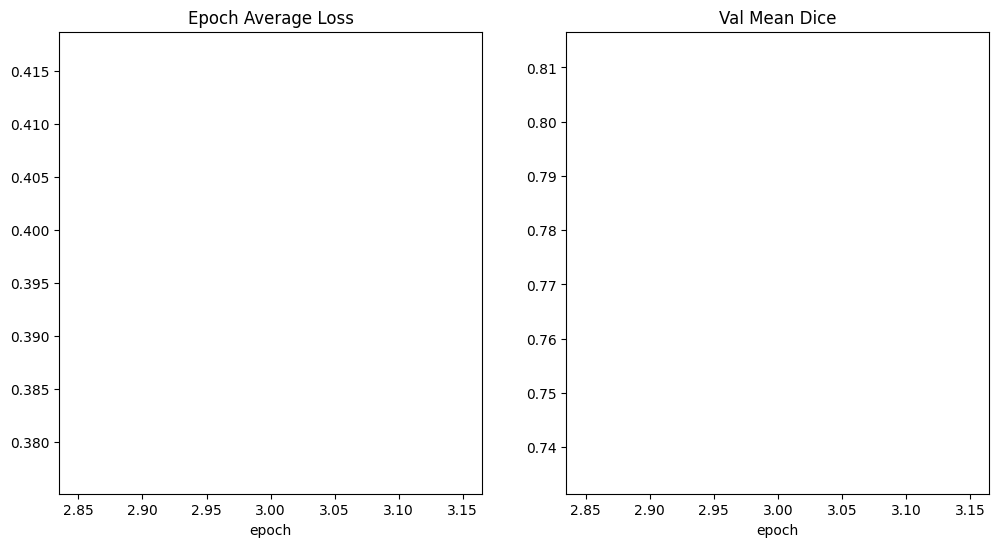

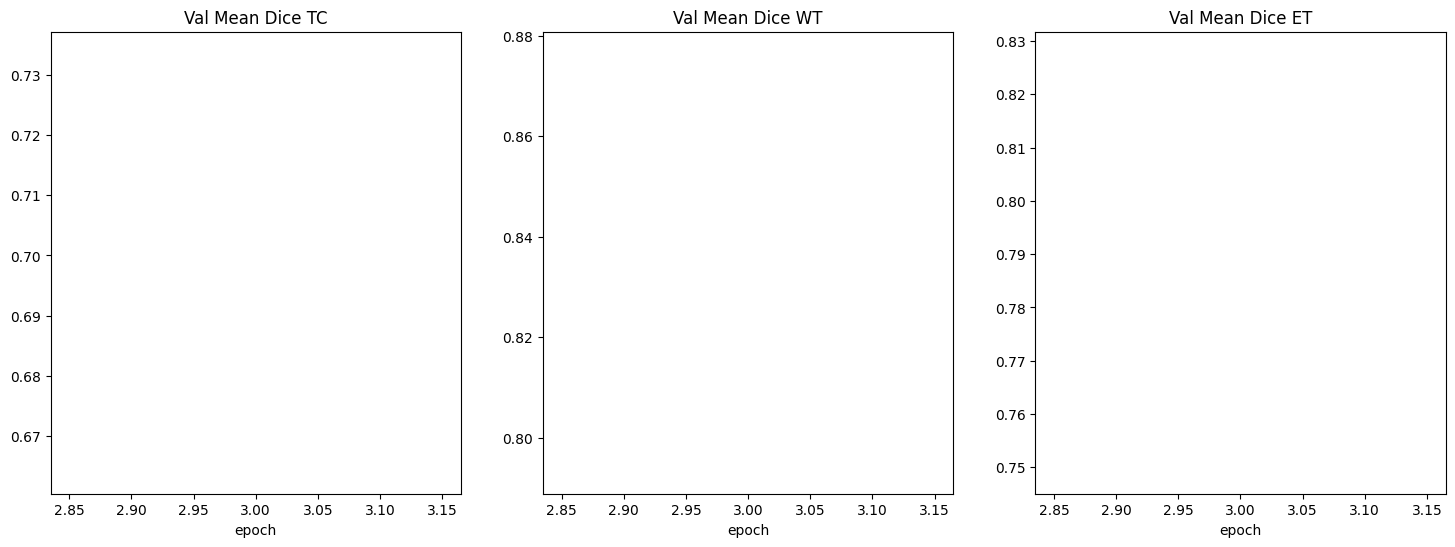

In [29]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
plt.xlabel("epoch")
plt.plot(trains_epoch, loss_epochs, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
plt.xlabel("epoch")
plt.plot(trains_epoch, dices_avg, color="green")
plt.show()
plt.figure("train", (18, 6))
plt.subplot(1, 3, 1)
plt.title("Val Mean Dice TC")
plt.xlabel("epoch")
plt.plot(trains_epoch, dices_tc, color="blue")
plt.subplot(1, 3, 2)
plt.title("Val Mean Dice WT")
plt.xlabel("epoch")
plt.plot(trains_epoch, dices_wt, color="brown")
plt.subplot(1, 3, 3)
plt.title("Val Mean Dice ET")
plt.xlabel("epoch")
plt.plot(trains_epoch, dices_et, color="purple")
plt.show()

In [30]:
print(f"train completed, best average dice: {val_acc_max:.4f} ")

train completed, best average dice: 0.7740 


In [31]:
%cd /content/drive/MyDrive/EECS442
data_dir = "./data/"
case_num = "01619"

test_files = [
    {
        "image": [
            os.path.join(
                data_dir,
                "TrainingData/BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_flair.nii.gz",
            ),
            os.path.join(
                data_dir,
                "TrainingData/BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_t1ce.nii.gz",
            ),
            os.path.join(
                data_dir,
                "TrainingData/BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_t1.nii.gz",
            ),
            os.path.join(
                data_dir,
                "TrainingData/BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_t2.nii.gz",
            ),
        ],
        "label": os.path.join(
            data_dir,
            "TrainingData/BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_seg.nii.gz",
        ),
    }
]

test_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image", "label"]),
        transforms.ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

test_ds = data.Dataset(data=test_files, transform=test_transform)

test_loader = data.DataLoader(
    test_ds,
    batch_size=1,
    shuffle=False,
    num_workers=8,
    pin_memory=True,
)

/content/drive/.shortcut-targets-by-id/1w_pSrzSOj3H2lluEXNwazzJe5p_Ak2xN/EECS442


In [32]:
model.load_state_dict(torch.load(os.path.join(root_dir, "model.pt"))["state_dict"])
model.to(device)
model.eval()

model_inferer_test = partial(
    sliding_window_inference,
    roi_size=[roi[0], roi[1], roi[2]],
    sw_batch_size=1,
    predictor=model,
    overlap=0.6,
)


with torch.no_grad():
    for batch_data in test_loader:
        image = batch_data["image"].cuda()
        prob = torch.sigmoid(model_inferer_test(image))
        seg = prob[0].detach().cpu().numpy()
        seg = (seg > 0.5).astype(np.int8)
        seg_out = np.zeros((seg.shape[1], seg.shape[2], seg.shape[3]))
        seg_out[seg[1] == 1] = 2
        seg_out[seg[0] == 1] = 1
        seg_out[seg[2] == 1] = 4

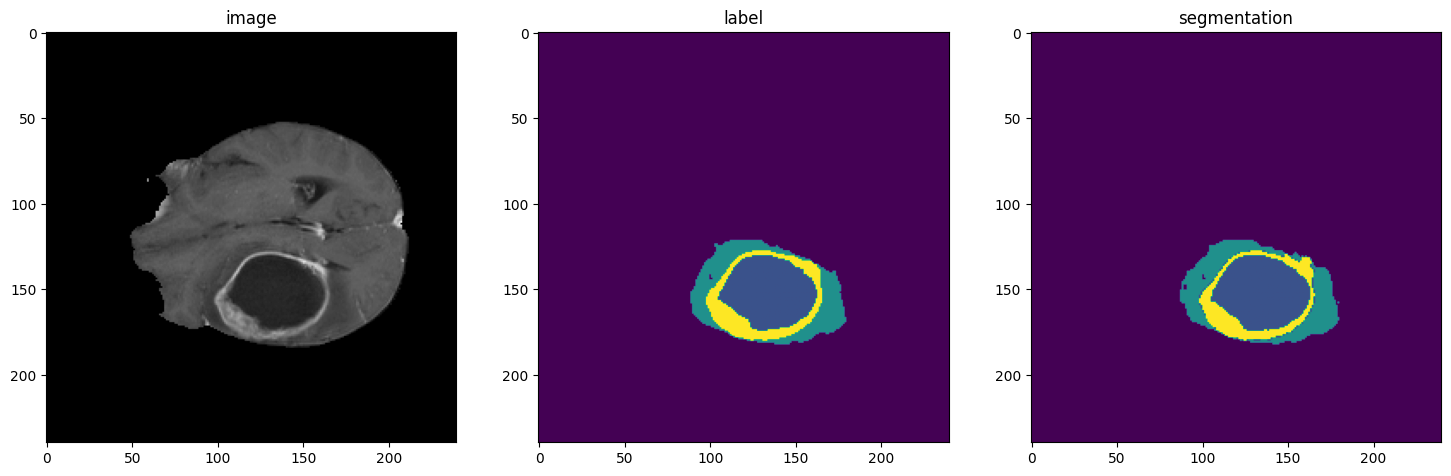

In [33]:
slice_num = 67
img_add = os.path.join(
    data_dir,
    "TrainingData/BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_t1ce.nii.gz",
)
label_add = os.path.join(
    data_dir,
    "TrainingData/BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_seg.nii.gz",
)
img = nib.load(img_add).get_fdata()
label = nib.load(label_add).get_fdata()
plt.figure("image", (18, 6))
plt.subplot(1, 3, 1)
plt.title("image")
plt.imshow(img[:, :, slice_num], cmap="gray")
plt.subplot(1, 3, 2)
plt.title("label")
plt.imshow(label[:, :, slice_num])
plt.subplot(1, 3, 3)
plt.title("segmentation")
plt.imshow(seg_out[:, :, slice_num])
plt.show()

# Evaluate model for brats2020

